In [1]:
# Autosave each 30s
%autosave 30

import numpy as np
import pandas as pd
import pickle as pkl
import tensorflow as tf
import os
import timeit
import copy
import gc
import math
import time
import scipy

from scipy import stats
from scipy.special import erfc
from scipy.signal import fftconvolve
from itertools import product, chain, combinations
from collections import defaultdict, Counter, OrderedDict
from tqdm import tqdm

#sklearn
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer

#skimage
import skimage
from skimage import io, transform, color
from skimage.transform import resize

#IPython imports
from IPython.display import Image, display, clear_output
from IPython.core.display import HTML
from IPython.display import FileLink, FileLinks

#matplotlib
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%matplotlib inline

#https://matplotlib.org/users/customizing.html
matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.01
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20
# Configuring latex fonts
matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble=r'\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble=r'\usepackage[english]{babel}')
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')

%load_ext autoreload
%autoreload 1
# Below comes the list of modules which is automatically reimported
# %aimport cs231n.classifiers.k_nearest_neighbor

Autosaving every 30 seconds


In [2]:
import sys
library_path = '../../../'
if library_path not in sys.path:
    sys.path.append(library_path)
    
CIFAR10_DIR = '../../../datasets/CIFAR10'

from ml.utils import get_CIFAR10_data, load_CIFAR10
from ml.generators import BatchGenerator
from ml.utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from ml.neural_network.cs231n.second.layers import *
from ml.neural_network.cs231n.second.optimizers import *
from ml.neural_network.cs231n.second.solver import Solver
from ml.neural_network.cs231n.second.fcn import FullyConnectedNet
from ml.neural_network.cs231n.second.two_layer_net import TwoLayerNet

from ml.neural_network.cs231n.second.conv_layers import *
from ml.neural_network.cs231n.second.conv_layers_fast import *

#from ml.linear_model import svm_loss_naive, svm_loss_vectorized, softmax_loss_naive, softmax_loss_vectorized
#from ml.neural_network import Sequential, NetworkTrainer
#from ml.neural_network.layers import Dense, Dropout, SoftMax
#from ml.neural_network.nonlinearities import ReLU, LeakyReLU, ELU, SoftPlus
#from ml.neural_network.criterions import MulticlassLogLoss

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

<a id='toc'></a>
# Table of Contents
* [1. Fully-Connected Neural Nets](#fcn)
    * [1.2 ReLU layer](#fcn_relu)
        * [1.2.1 ReLU layer: foward](#fcn_relu_forw)
        * [1.2.2 ReLU layer: backward](#fcn_relu_forw)
    * [1.3 "Sandwich" layers](#fcn_sand)
    * [1.4 Loss layers: Softmax and SVM](#fcn_loss)
    * [1.7 Two-layer network](#fcn_twolayer)
    * [1.8 Solver](#fcn_solver)
        * [1.9.3 Comparison of update rules](#update_comp)
    * [1.10 Multilayer network](#fcn_mult)
        * [1.10.2 Initial loss and gradient check](#fcn_check)
        * [1.10.3 Batch normalization](#bn_mult)
            * [1.10.3.1 Test](#bn_test)
            * [1.10.3.2 Batch normalization for deep networks](#bn_deep)
            * [1.10.3.3 Batch normalization and initialization](#bn_deep_init)
        * [1.10.4 Dropout](#fcn_dropout)
        * [1.10.5 Final model](#fcn_final)
            * [1.10.5.1 Train model](#fcn_final_train)
            * [1.10.5.2 Test model](#fcn_final_test)

* [2. Convolutional Networks](#cnn)
    * [2.1 Convolution](#cnn_conv)
        * [2.1.1 Convolution: Naive forward pass](#cnn_conv_forw)
        * [2.1.2 Aside: Image processing via convolutions](#cnn_conv_aside)
        * [2.1.3 Convolution: Naive backward pass](#cnn_conv_back)
    * [2.2 Max pooling](#max_pooling)
        * [2.2.1 Max pooling: Naive forward](#cnn_max_pooling_forw)
        * [2.2.2 Max pooling: Naive backward](#cnn_max_pooling_back)
    * [2.3 Fast layers](#cnn_fast)
    * [2.4 Convolutional "sandwich" layers](#cnn_sand)
    * [2.5 Spatial Batch Normalization](#cnn_spatial)
        * [2.5.1 Spatial batch normalization: forward](#cnn_spatial_forw)
        * [2.5.2 Spatial batch normalization: backward](#cnn_spatial_back)
    * [2.6 Three Layer ConvNet](#cnn_three)
        * [2.6.1 Sanity check loss](#cnn_three_sanity)
        * [2.6.2 Gradient check](#cnn_three_grad)
        * [2.6.3 Overfit small data](#cnn_three_overfit)
        * [2.6.4 Train net](#cnn_three_train)
        * [2.6.5 Visualize filters](#cnn_three_visualize)

* [3. TensorFlow](#tf)
    * [3.1 Introduction](#tf_intro)
    * [3.2 Load dataset](#tf_load)
    * [3.3 Example tensorflow model](#tf_example)
        * [3.3.1 Some useful utilities](#tf_some)
        * [3.3.2 The example model itself](#tf_example)
        * [3.3.3 TensorFlow detail](#tf_detail)
        * [3.3.4 Training the model on one epoch](#tf_training)
    * [3.4 Training a specific model](#tf_specific)
        * [GPU](#tf_gpu)
    * [3.5 Train a _great_ model on CIFAR-10!](#tf_cifar10_great)
        * [Model 1](#tf_model1)
        * [Model 2](#tf_model2)
        * [Extra credit description](#tf_extra)
    * [Tutorial](#tf_tutorial)
        * [Constants](#tf_constants)
        * [Variables](#tf_variables)

<a id='fcn'></a>
# 1. Fully-Connected Neural Nets [[toc](#toc)]
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

<a id='cnn_conv'></a>
## 2.1 Convolution [[toc](#toc)]

In [95]:
from scipy.signal import fftconvolve
from scipy.signal import correlate2d

def conv_forward(X, W, biases, conv_param, method='fft'):
    """
    A naive implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width HH.

    Input:
    - X: Input data of shape (N, C, H, W)
    - W: Filter weights of shape (F, C, HH, WW)
    - biases: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (X, W, biases, conv_param)
    """
    
    
    pad    = conv_param['pad']    # Obtaining 'pad'
    stride = conv_param['stride'] # Obtaining 'stride'
    
    # No shape checks used here for now
    n_samples, n_channels, image_h,  image_w  = X.shape
    n_filters, n_channels, filter_h, filter_w = W.shape
    n_filters, = biases.shape
    
    # Finding convolutions
    padded_image_h = image_h + 2 * pad; padded_image_w = image_w + 2 * pad
    assert (padded_image_h - filter_h) % stride == 0, 'Incorrect height padding'
    assert (padded_image_w - filter_w) % stride == 0, 'Incorrect width padding'
    output_h = 1 + (padded_image_h - filter_h) // stride
    output_w = 1 + (padded_image_w - filter_w) // stride
    out = np.zeros((n_samples, n_filters, output_h, output_w), dtype=np.float64)
    
    padding = ((0,), (0,), (pad,), (pad,))
    images = np.pad(X, padding, mode='constant')
    if method == 'fft':
        weights = W[:, :, ::-1, ::-1]
        corr_func = fftconvolve
    else:
        weights = W
        corr_func = correlate2d
    for n_sample, n_filter, n_channel in product(range(n_samples), range(n_filters), range(n_channels)):
        c = corr_func(images[n_sample, n_channel], weights[n_filter, n_channel], mode='valid')
        out[n_sample, n_filter] += c[::stride, ::stride]
    out += biases[None, :, None, None]
    cache = (X, W, biases, conv_param)
    return out, cache


def conv_forward_naive(X, W, biases, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width HH.

    Input:
    - X: Input data of shape (N, C, H, W)
    - W: Filter weights of shape (F, C, HH, WW)
    - biases: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (X, W, biases, conv_param)
    """
    
    
    pad    = conv_param['pad']    # Obtaining 'pad'
    stride = conv_param['stride'] # Obtaining 'stride'
    
    # No shape checks used here for now
    n_samples, n_channels, image_h,  image_w  = X.shape
    n_filters, n_channels, filter_h, filter_w = W.shape
    n_filters, = biases.shape
    
    # Finding convolutions
    padded_image_h = image_h + 2 * pad; padded_image_w = image_w + 2 * pad
    assert (padded_image_h - filter_h) % stride == 0, 'Incorrect height padding'
    assert (padded_image_w - filter_w) % stride == 0, 'Incorrect width padding'
    output_h = 1 + (padded_image_h - filter_h) // stride
    output_w = 1 + (padded_image_w - filter_w) // stride
    out = np.zeros((n_samples, n_filters, output_h, output_w), dtype=np.float64)
    
    padding = ((0,), (0,), (pad,), (pad,))
    images = np.pad(X, padding, mode='constant')
    
    W_flattened = W.reshape((n_filters, -1))
    for n_sample in range(n_samples):
        image = images[n_sample]
        #assert image.shape == padded_image_size
        new_i = 0
        for i in range(0, padded_image_h - filter_h + 1, stride):
            new_j = 0
            for j in range(0, padded_image_w - filter_w + 1, stride):
                col = image[:, i:i + filter_h, j:j + filter_w].flatten()
                #assert col.shape == (n_channels * filter_h * filter_w)
                out[n_sample, :, new_i, new_j] = np.sum(np.multiply(col[None, :], W_flattened), axis=1)
                new_j += 1
            new_i += 1
    out += biases[None, :, None, None]
    cache = (X, W, biases, conv_param)
    return out, cache

In [96]:
def conv_backward(Y_grad, cache, method='fft'):
    """
    Inputs:
    - output_grad Upstream derivatives.
    - cache: A tuple of (X, W, b, conv_param) as in conv_forward_naive:
        - conv_param: A dictionary with the following keys:
          - 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
          - 'pad': The number of pixels that will be used to zero-pad the input.
     
    Returns a tuple of:
    - X_grad: Gradient with respect to X
    - W_grad: Gradient with respect to W
    - b_grad: Gradient with respect to biases
    """
    X, W, b, conv_param = cache[0], cache[1], cache[2], cache[3]
    pad    = conv_param['pad']    # Obtaining 'pad'
    stride = conv_param['stride'] # Obtaining 'stride'
    
    n_samples, n_filters, output_h, output_w = Y_grad.shape
    n_samples, n_channels, image_h,  image_w = X.shape
    n_filters, = b.shape
    n_filters, n_channels, filter_h, filter_w = W.shape
    padded_image_h = image_h + 2 * pad; padded_image_w = image_w + 2 * pad
    assert (padded_image_h - filter_h) % stride == 0
    assert (padded_image_w - filter_w) % stride == 0
    assert output_h == (padded_image_h - filter_h) // stride + 1
    assert output_w == (padded_image_W - filter_w) // stride + 1
    X_grad = np.zeros_like(X)
    W_grad = np.zeros_like(W)
    b_grad = np.zeros_like(b)

    full_Y_grad = np.zeros((n_samples, n_filters, padded_image_h - filter_h + 1, padded_image_h - filter_w + 1),
                            dtype=np.float64)
    assert full_Y_grad[:, :, ::stride, ::stride].shape = Y_grad.shape
    full_Y_grad[:, :, ::stride, ::stride] = Y_grad
    
    for n_sample in range(n_samples)
        pass
    
    # Finding X_grad
    for n_sample in range(n_samples):
        for n_channel in range(n_channels):
            for h, w in product(range(image_h), range(image_w)):
                # Finding derivative over X[n_sample, n_channel, h, w]
                h += pad; w += pad # Coordinates in the padded X
                i_low = int(np.ceil((h - filter_h + 1) / stride)); i_max = h // stride
                j_low = int(np.ceil((w - filter_w + 1) / stride)); j_max = w // stride
                i_range = range(max(0, i_low), min(output_h - 1, i_max) + 1)
                j_range = range(max(0, j_low), min(output_w - 1, j_max) + 1)
                for i, j in product(i_range, j_range):
                    a = h - i * stride
                    b = w - j * stride
                    assert (a >= 0) & (a < filter_h)
                    assert (b >= 0) & (b < filter_w)
                    assert (i >= 0) & (i < output_h)
                    assert (j >= 0) & (j < output_w)
                    X_grad[n_sample, n_channel, h - pad, w - pad] +=\
                        np.sum(W[np.arange(n_filters), n_channel, a, b] * Y_grad[n_sample, np.arange(n_filters), i, j])
    
    X_padded = np.pad(X, [(0, 0), (0, 0), (pad, pad), (pad, pad)], mode='constant')
    assert X_padded.shape == (n_samples, n_channels, 2 * pad + image_h, 2 * pad + image_w)
    
    for n_filter in range(n_filters): 
        for n_channel in range(n_channels):
            for h, w in product(range(filter_h), range(filter_w)):
                # Finding derivative over W[n_filter, n_channel, h, w]
                for i, j in product(range(output_h), range(output_w)):
                    W_grad[n_filter, n_channel, h, w] +=\
                        np.sum(X_padded[:, n_channel, i * stride + h, j * stride + w] * Y_grad[:, n_filter, i, j])
                    # Finding derivative over b[n_filter]
        b_grad[n_filter] += np.sum(Y_grad[:, n_filter, :, :])
    return X_grad, W_grad, b_grad   


def conv_backward_naive(Y_grad, cache):
    """
    A naive implementation of the backward pass for a convolutional layer.

    Inputs:
    - output_grad Upstream derivatives.
    - cache: A tuple of (X, W, b, conv_param) as in conv_forward_naive:
        - conv_param: A dictionary with the following keys:
          - 'stride': The number of pixels between adjacent receptive fields in the horizontal and vertical directions.
          - 'pad': The number of pixels that will be used to zero-pad the input.
     
    Returns a tuple of:
    - X_grad: Gradient with respect to X
    - W_grad: Gradient with respect to W
    - b_grad: Gradient with respect to biases
    """
    X, W, b, conv_param = cache[0], cache[1], cache[2], cache[3]
    
    # Obtaining 'pad'
    pad = conv_param['pad']
    # Obtaining 'stride'
    stride = conv_param['stride']
    
    n_samples, n_filters, output_h, output_w = Y_grad.shape
    n_samples, n_channels, image_h,  image_w = X.shape
    n_filters, = b.shape
    n_filters, n_channels, filter_h, filter_w = W.shape

    X_grad = np.zeros(X.shape, dtype=np.float64)
    W_grad = np.zeros(W.shape, dtype=np.float64)
    b_grad = np.zeros(b.shape, dtype=np.float64)
    
    # Finding X_grad
    for n_sample in range(n_samples):
        for n_channel in range(n_channels):
            for h, w in product(range(image_h), range(image_w)):
                # Finding derivative over X[n_sample, n_channel, h, w]
                h += pad; w += pad # Coordinates in the padded X
                i_low = int(np.ceil((h - filter_h + 1) / stride)); i_max = h // stride
                j_low = int(np.ceil((w - filter_w + 1) / stride)); j_max = w // stride
                i_range = range(max(0, i_low), min(output_h - 1, i_max) + 1)
                j_range = range(max(0, j_low), min(output_w - 1, j_max) + 1)
                for i, j in product(i_range, j_range):
                    a = h - i * stride
                    b = w - j * stride
                    assert (a >= 0) & (a < filter_h)
                    assert (b >= 0) & (b < filter_w)
                    assert (i >= 0) & (i < output_h)
                    assert (j >= 0) & (j < output_w)
                    X_grad[n_sample, n_channel, h - pad, w - pad] +=\
                        np.sum(W[np.arange(n_filters), n_channel, a, b] * Y_grad[n_sample, np.arange(n_filters), i, j])
    
    X_padded = np.pad(X, [(0, 0), (0, 0), (pad, pad), (pad, pad)], mode='constant')
    assert X_padded.shape == (n_samples, n_channels, 2 * pad + image_h, 2 * pad + image_w)
    
    for n_filter in range(n_filters): 
        for n_channel in range(n_channels):
            for h, w in product(range(filter_h), range(filter_w)):
                # Finding derivative over W[n_filter, n_channel, h, w]
                for i, j in product(range(output_h), range(output_w)):
                    W_grad[n_filter, n_channel, h, w] +=\
                        np.sum(X_padded[:, n_channel, i * stride + h, j * stride + w] * Y_grad[:, n_filter, i, j])
                    # Finding derivative over b[n_filter]
        b_grad[n_filter] += np.sum(Y_grad[:, n_filter, :, :])
    return X_grad, W_grad, b_grad    

<a id='cnn_conv_forw'></a>
### 2.1.1 Convolution: Naive forward pass  [[toc](#toc)]
The core of a convolutional network is the convolution operation. In the file `ml/neural_network/cs231n/second/conv_layers_naive.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [93]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward(x, w, b, conv_param, method='2d')
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around 2e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.21214764175e-08


<a id='cnn_conv_aside'></a>
### 2.1.2 Aside: Image processing via convolutions [[toc](#toc)]
As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check. 

/home/alexander/anaconda3/envs/tensorflow/lib/python3.4/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()
/home/alexander/anaconda3/envs/tensorflow/lib/python3.4/site-packages/ipykernel/__main__.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/alexander/anaconda3/envs/tensorflow/lib/python3.4/site-packages/ipykernel/__main__.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


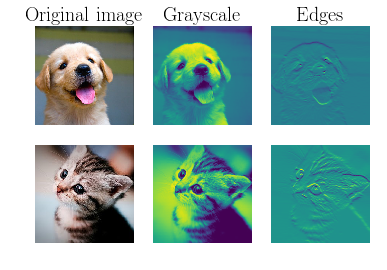

In [4]:
from scipy.misc import imread, imresize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

<a id='cnn_conv_back'></a>
### 2.1.3 Convolution: Naive backward pass [[toc](#toc)]
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `cs231n/layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [6]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around 1e-8'
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.15980316116e-08
dw error:  2.24710943494e-10
db error:  3.37261539588e-11


<a id='cnn_max_pooling'></a>
## 2.2 Max pooling [[toc](#toc)]

<a id='cnn_max_pooling_forw'></a>
### 2.2.1 Max pooling: Naive forward  [[toc](#toc)]
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `cs231n/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [7]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.16666651573e-08


<a id='cnn_max_pooling_back'></a>
### 2.2.2 Max pooling: Naive backward [[toc](#toc)]
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `cs231n/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [8]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be around 1e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223e-12


<a id='cnn_fast'></a>
## 2.3 Fast layers [[toc](#toc)]
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `cs231n/fast_layers.py`.

The fast convolution implementation depends on a Cython extension; to compile it you need to run the following from the `cs231n` directory:

```bash
python setup.py build_ext --inplace
```

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [104]:
from time import time

np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 0.265352s
Fast: 0.013812s
Speedup: 19.211279x
Difference:  1.97056314066e-11

Testing conv_backward_fast:
Naive: 9.091491s
Fast: 0.009599s
Speedup: 947.084892x
dx difference:  2.0126604133e-11
dw difference:  2.57766409929e-13
db difference:  3.13938580256e-15


In [10]:
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 1.019685s
fast: 0.002434s
speedup: 418.972375x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.092232s
speedup: 8.984834x
dx difference:  0.0


<a id='cnn_sand'></a>
## 2.4 Convolutional "sandwich" layers [[toc](#toc)]
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `cs231n/layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks.

In [10]:
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  4.39750283427e-09
dw error:  3.65169939729e-09
db error:  7.05481262422e-10


In [12]:
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  8.03522627181e-09
dw error:  2.09024057453e-10
db error:  3.28795840264e-10


<a id='cnn_spatial'></a>
## 2.5 Spatial Batch Normalization [[toc](#toc)]
We already saw that batch normalization is a very useful technique for training deep fully-connected networks. Batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different imagesand different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.

<a id='cnn_spatial_forw'></a>
### 2.5.1 Spatial batch normalization: forward [[toc](#toc)]

In the file `cs231n/layers.py`, implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [23]:
np.random.seed(231)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(axis=(0, 2, 3)))
print('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(axis=(0, 2, 3)))
print('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 9.33463814  8.90909116  9.11056338]
  Stds:  [ 3.61447857  3.19347686  3.5168142 ]
After spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [  6.27276009e-16   6.13398221e-16  -1.05471187e-16]
  Stds:  [ 0.99999723  0.99999687  0.99999716]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 4, 5)
  Means:  [ 6.  7.  8.]
  Stds:  [ 2.9999917   3.99998747  4.99998578]


In [19]:
np.random.seed(231)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
  x = 2.3 * np.random.randn(N, C, H, W) + 13
  spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=(0, 2, 3)))
print('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.08034378  0.07562855  0.05716351  0.04378368]
  stds:  [ 0.96718413  1.02996788  1.02887272  1.00585232]


<a id='cnn_spatial_back'></a>
### 2.5.2 Spatial batch normalization: backward [[toc](#toc)]
In the file `cs231n/layers.py`, implement the backward pass for spatial batch normalization in the function `spatial_batchnorm_backward`. Run the following to check your implementation using a numeric gradient check:

In [26]:
np.random.seed(231)
N, C, H, W = 2, 3, 4, 5
x = 5 * np.random.randn(N, C, H, W) + 12
gamma = np.random.randn(C)
beta = np.random.randn(C)
dout = np.random.randn(N, C, H, W)

bn_param = {'mode': 'train'}
fx = lambda x: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: spatial_batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = spatial_batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = spatial_batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  3.51419372256e-06
dgamma error:  1.7957991295e-11
dbeta error:  3.27560872528e-12


<a id='cnn_three'></a>
## 2.6 Three-layer ConvNet  [[toc](#toc)]
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `cs231n/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Run the following cells to help you debug:

In [3]:
from ml.neural_network.cs231n.second.padding import *

In [38]:
from builtins import object
import numpy as np

#from cs231n.layers import *
#from cs231n.fast_layers import *
#from cs231n.layer_utils import *

class ThreeLayerConvNet(object):
    """
    A three-layer convolutional network with the following architecture:

    conv - relu - 2x2 max pool - affine - relu - affine - softmax

    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels.
    """

    def __init__(self, input_dim=(3, 32, 32), 
                 n_filters=32, filter_size=7,           # convolution params
                 hidden_dim=100,                          # first affine layer
                 n_classes=10,                          # second affine layer
                 weight_scale=None, reg=0.0,
                 use_batchnorm=False,
                 random_state=0,
                 dtype=np.float64,
                 debug=False):
        """
        Initialize a new network.

        Inputs:
        - input_dim: Tuple (C, H, W) giving size of input data
        - n_filters: Number of filters to use in the convolutional layer
        - filter_size: Size of filters to use in the convolutional layer
        - hidden_dim: Number of units to use in the fully-connected hidden layer
        - n_classes: Number of scores to produce from the final affine layer.
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - use_batchnorm: 
        - reg: Scalar giving L2 regularization strength
        - dtype: numpy datatype to use for computation.
        """
        
    
        self.reg = reg
        self.dtype = dtype
        self.random_state = random_state
        self.gen = np.random.RandomState(random_state)
        self.use_batchnorm = use_batchnorm
        self.debug = debug
        # Shapes and dimensions
        
        n_channels, image_h, image_w = input_dim
        self.input_dim = input_dim
        self.n_channels = n_channels; self.image_h = image_h; self.image_w = image_w
        self.n_filters = n_filters
        self.n_classes = n_classes

        self.params = {}
        self.output_shapes = {}
        
        # Convolution layer parameters
        assert image_h == image_w, 'Image height and width must be equal. Otherwise padding problem can occur.'
        conv_stride = 1 # convolution uses stride = 1
        assert filter_size % 2 == 1, 'Filter size must be odd.'
        conv_pad = (filter_size - 1) // 2
        output_h = float(image_h + 2 * conv_pad - filter_size) / conv_stride + 1
        output_w = float(image_w + 2 * conv_pad - filter_size) / conv_stride + 1
        assert output_h == int(output_h), 'Conv layer: height padding is incorrect'
        assert output_w == int(output_w), 'Conv layer: width padding is incorrect'
        assert output_h == output_w, 'Output of the first conv layer must have equal height and width.'
        assert output_h == image_h, 'Output size of the conv layer must be equal to the input one.'
        output_h = int(output_h); output_w = int(output_w)
        self.output_shapes['conv'] = (-1, n_filters, output_h, output_w)
        # pass conv_param to the forward pass for the convolutional layer
        self.conv_param = {}
        self.conv_param['stride'] = conv_stride
        self.conv_param['filter_size'] = filter_size
        self.conv_param['pad'] = conv_pad
        # Convolution weights and biases
        if weight_scale is None:
            scale = 1.0 /  np.sqrt(n_channels * filter_size * filter_size)
        else:
            scale = weight_scale

        self.params['W1'] = self.gen.normal(size=(n_filters, n_channels, filter_size, filter_size), scale=scale)
        self.params['b1'] = np.zeros((n_filters))
        
        # Batchnorm
        if self.use_batchnorm:
            self.bn_param = {'momentum': 0.9, 'eps': 1e-8, 'mode': 'train'}
            self.params['gamma'] = np.ones(n_filters)
            self.params['beta'] = np.zeros(n_filters)
        
        # Pooling parameters
        # pass pool_param to the forward pass for the max-pooling layer
        self.pool_param = {}
        self.pool_param['pool_height'] = 2
        self.pool_param['pool_width']  = 2
        self.pool_param['stride']      = 2
        assert output_h % 2 == 0, 'Output height of the conv layer must be even.'
        assert output_w % 2 == 0, 'Output width of the conv layer must be even.'
        output_h //= 2
        output_w //= 2
        self.output_shapes['pool'] = (-1, n_filters, output_h, output_w)
        
        # First affine layer
        affine_input = int(n_filters * output_h * output_w)
        if weight_scale is None:
            scale = 1.0 / np.sqrt(affine_input)
        else:
            scale = weight_scale
        self.params['W2'] = self.gen.normal(size=(affine_input, hidden_dim), scale=scale)
        self.params['b2'] = np.zeros((hidden_dim,))
        self.output_shapes['affine1'] = (-1, hidden_dim)
        
        # Second affine layer
        if weight_scale is None:
            scale = 1.0 / np.sqrt(hidden_dim)
        else:
            scale = weight_scale
        self.params['W3'] = self.gen.normal(size=(hidden_dim, n_classes), scale=scale)
        self.params['b3'] = np.zeros((n_classes,))
        self.output_shapes['softmax'] = (-1, n_classes)

        for k, v in self.params.items():
            self.params[k] = v.astype(self.dtype)
        
    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the three-layer convolutional network.

        Input / output: Same API as TwoLayerNet in fc_net.py.
        """
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']

        n_samples, n_channels, image_h, image_w = X.shape
        assert (n_channels, image_h, image_w) == self.input_dim
        if self.use_batchnorm:
            mode = 'test' if y is None else 'train'
            self.bn_param['mode'] = mode
        
        outputs = {}; caches = {}
        
        if self.debug: print('FORWARD\nX1.shape', X.shape)
            
        if self.use_batchnorm:
            outputs['conv_bn_relu'], caches['conv_bn_relu'] = conv_bn_relu_forward(
                X, W1, b1, self.params['gamma'], self.params['beta'], self.conv_param, self.bn_param)
            outputs['pool'], caches['pool'] = max_pool_forward_fast(outputs['conv_bn_relu'], self.pool_param)
            X2 = outputs['pool']
        else:
            outputs['conv_relu_pool'], caches['conv_relu_pool'] = conv_relu_pool_forward(
                X, W1, b1, self.conv_param, self.pool_param)
            X2 = outputs['conv_relu_pool']
        X2_shape = X2.shape   
        if self.debug: print('X2.shape', X2.shape)
            
        assert X2.shape[1:] == self.output_shapes['pool'][1:]
        X2 = X2.reshape((n_samples, -1))
        if self.debug: print('X2 reshaped to {} for passing to affine layer with W.shape = {}'.format(
            X2.shape, W2.shape))
        
        
        outputs['affine_relu'], caches['affine_relu'] = affine_relu_forward(X2, W2, b2)
        X3 = outputs['affine_relu']
        if self.debug: print('X3.shape', X3.shape)
        
        outputs['affine'], caches['affine'] = affine_forward(X3, W3, b3)
        scores = outputs['affine']
        if self.debug: print('scores.shape', scores.shape)
        assert scores.shape == (n_samples, self.n_classes)
       
        if y is None:
            return scores

        self.grads = {}
        
        loss, scores_grad = softmax_loss(scores, y)
        if self.debug: print('\bBACKWARD\nscores_grad.shape {}, loss = {}'.format(scores_grad.shape, loss))
            
        X3_grad, W3_grad, b3_grad = affine_backward(scores_grad, caches['affine'])
        assert W3_grad.shape == W3.shape; assert b3_grad.shape == b3.shape
        loss += 0.5 * self.reg * np.sum(W3 ** 2)
        W3_grad += self.reg * W3
        self.grads['W3'] = W3_grad; self.grads['b3'] = b3_grad
        if self.debug: print('X3_grad.shape', X3_grad.shape)
        
        X2_grad, W2_grad, b2_grad = affine_relu_backward(X3_grad, caches['affine_relu'])
        assert W2_grad.shape == W2.shape; assert b2_grad.shape == b2.shape
        loss += 0.5 * self.reg * np.sum(W2 ** 2)
        W2_grad += self.reg * W2
        self.grads['W2'] = W2_grad; self.grads['b2'] = b2_grad
        if self.debug: print('X2_grad.shape', X2_grad.shape)
        X2_grad = X2_grad.reshape(X2_shape)
        if self.debug: print('X2_grad reshaped to', X2_grad.shape)
            
        if self.use_batchnorm:
            pool_grad = max_pool_backward_fast(X2_grad, caches['pool'])
            X1_grad, W1_grad, b1_grad, gamma_grad, beta_grad = conv_bn_relu_backward(pool_grad, caches['conv_bn_relu'])
            self.grads['gamma'] = gamma_grad
            self.grads['beta'] = beta_grad
        else:
            X1_grad, W1_grad, b1_grad = conv_relu_pool_backward(X2_grad, caches['conv_relu_pool'])
        assert W1_grad.shape == W1.shape; assert b1_grad.shape == b1.shape
        loss += 0.5 * self.reg * np.sum(W1 ** 2)
        W1_grad += self.reg * W1
        self.grads['W1'] = W1_grad; self.grads['b1'] = b1_grad
        if self.debug: 
            print('X1_grad.shape', X1_grad.shape)
            for param_name in ['W1', 'b1', 'W2', 'b2', 'W3', 'b3']:
                print(param_name, self.params[param_name].shape, self.grads[param_name].shape)
            
        return loss, self.grads

<a id='cnn_three_sanity'></a>
### 2.6.1 Sanity check loss [[toc](#toc)]
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [39]:
model = ThreeLayerConvNet(n_filters=32, use_batchnorm=True, debug=False)

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.87713606659
Initial loss (with regularization):  38.295943352


<a id='cnn_three_grad'></a>
### 2.6.2 Gradient check [[toc](#toc)]
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to 1e-2.

In [42]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(n_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64, debug=False, use_batchnorm=True)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 2.221201e-08
W2 max relative error: 2.632249e-07
W3 max relative error: 2.969574e-09
b1 max relative error: 2.220447e-02
b2 max relative error: 3.167081e-10
b3 max relative error: 9.340024e-10
beta max relative error: 8.372573e-10
gamma max relative error: 1.236828e-09


<a id='cnn_three_overfit'></a>
### 2.6.3 Overfit small data [[toc](#toc)]
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [52]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2, use_batchnorm=True)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                    'learning_rate': 3e-3,
                    'learning_rate_decay': 0.99
                },
                verbose=True, 
                print_every_epoch=1)
model = solver.train()

num of epochs = 15
num of iterations = 30
iterations per epoch = 2
(Epoch 1/15) train acc: 0.16; val acc: 0.1, train loss: 5.5604; val loss: 5.7849
(Epoch 2/15) train acc: 0.27; val acc: 0.18, train loss: 3.6821; val loss: 3.7411
(Epoch 3/15) train acc: 0.29; val acc: 0.21, train loss: 2.4713; val loss: 2.7868
(Epoch 4/15) train acc: 0.47; val acc: 0.21, train loss: 1.7436; val loss: 2.5318
(Epoch 5/15) train acc: 0.52; val acc: 0.19, train loss: 1.6601; val loss: 2.8796
(Epoch 6/15) train acc: 0.44; val acc: 0.16, train loss: 1.6; val loss: 3.0541
(Epoch 7/15) train acc: 0.54; val acc: 0.18, train loss: 1.281; val loss: 2.8431
(Epoch 8/15) train acc: 0.64; val acc: 0.21, train loss: 1.1779; val loss: 2.784
(Epoch 9/15) train acc: 0.73; val acc: 0.22, train loss: 0.99798; val loss: 2.6947
(Epoch 10/15) train acc: 0.76; val acc: 0.23, train loss: 0.84658; val loss: 2.6323
(Epoch 11/15) train acc: 0.72; val acc: 0.21, train loss: 0.81998; val loss: 2.9283
(Epoch 12/15) train acc: 0.8; va

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

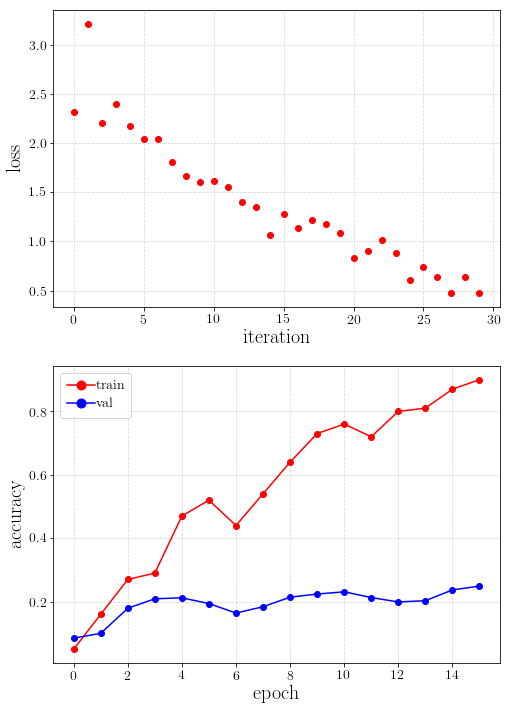

In [56]:
plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o', color='r', zorder=2)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid(linestyle='--', alpha=0.5)

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o', color='r', zorder=2)
plt.plot(solver.val_acc_history, '-o', color='b', zorder=2)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(linestyle='--', alpha=0.5)
plt.show()

<a id='cnn_three_train'></a>
### 2.6.4 Train net [[toc](#toc)]
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [58]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001, use_batchnorm=True)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every_iter=20)
model = solver.train()

num of epochs = 1
num of iterations = 980
iterations per epoch = 980
(Iteration 20/980) loss: 2.0902864855252563
(Iteration 40/980) loss: 1.7849973358864888
(Iteration 60/980) loss: 1.74543153511561
(Iteration 80/980) loss: 1.7848495819525667
(Iteration 100/980) loss: 1.6882001100268815
(Iteration 120/980) loss: 1.7037821808992661
(Iteration 140/980) loss: 1.7265996247014312
(Iteration 160/980) loss: 1.679504104275444
(Iteration 180/980) loss: 1.6388035647742514
(Iteration 200/980) loss: 1.3928123169657927
(Iteration 220/980) loss: 1.6826061904533702
(Iteration 240/980) loss: 1.66854406432848
(Iteration 260/980) loss: 1.5866789100571315
(Iteration 280/980) loss: 1.4117076069995693
(Iteration 300/980) loss: 1.5779107624995818
(Iteration 320/980) loss: 1.483004330651699
(Iteration 340/980) loss: 1.4447497796863897
(Iteration 360/980) loss: 1.5401995033662386
(Iteration 380/980) loss: 1.5864428970983107
(Iteration 400/980) loss: 1.487066796490936
(Iteration 420/980) loss: 1.71684151590361

In [60]:
scores = model.loss(data['X_val'])
y_pred = np.argmax(scores, axis=1)
y_true = data['y_val']
print(np.mean(y_pred == y_true))

0.543


<a id='cnn_three_visualize'></a>
### 2.6.5 Visualize filters [[toc](#toc)]
You can visualize the first-layer convolutional filters from the trained network by running the following:

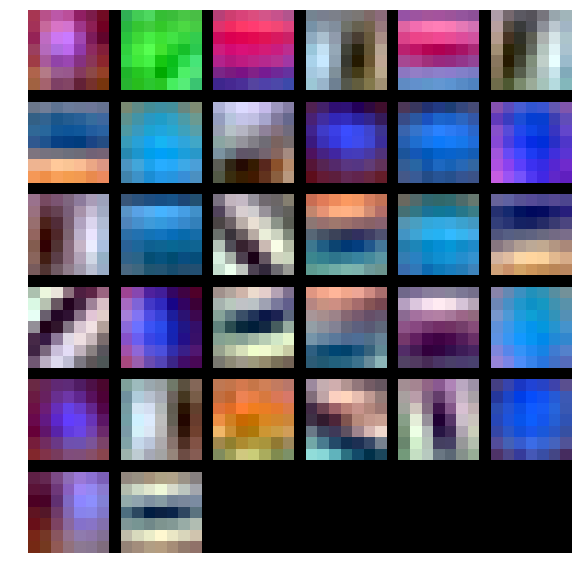

In [62]:
from ml.utils.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1), n_cols=6)
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(10, 10)
plt.show()

## Extra Credit Description [[toc](#toc)]
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.